In [49]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

Load and prepare data

In [64]:
return_sequences = False

# Variables relating to the data you want to load
n = 10000
time_span = 5
c = 100
time_step = 0.1
integration_time_step = 0.01
number_timesteps_predict = 1
std = 0

In [65]:
# Load the observations
name = f"{n}_{time_span}_{str(time_step).replace('.', '')}_{str(integration_time_step).replace('.', '')}_{number_timesteps_predict}_{std}"
dictionary = np.load(f"data_dictionaries/data_{name}.npy", allow_pickle=True).item()
observations = dictionary["observations"]
predictions = dictionary[c]
print(f'observations array shape = {observations.shape}')
print(f'predictions array shape = {predictions.shape}')

observations array shape = (10000, 51, 3)
predictions array shape = (10000, 3)


In [67]:
# Split into training and test data

frac = 0.9
num_samples = observations.shape[0]
cut_off = int(frac*num_samples)

train_x = observations[:cut_off,:-number_timesteps_predict, :]
test_x = observations[cut_off:,:-number_timesteps_predict, :]
train_answer = observations[:cut_off, -1, :]
test_answer = observations[cut_off:, -1, :]
train_prediction = predictions[:cut_off, :]
test_prediction = predictions[cut_off:, :]
print(f"shape of training data = {train_x.shape}")
print(f"shape of training predictions = {train_prediction.shape}")
print(f"shape of training answers = {train_answer.shape}")

shape of training data = (9000, 50, 3)
shape of training predictions = (9000, 3)
shape of training answers = (9000, 3)


Create the architecture

In [68]:
# Create the architecture
# model = keras.Sequential()

observation_input = layers.Input(shape=(None,3), name = 'input_ob')
observation_LSTM = layers.LSTM(64, input_shape=(None, 3), return_sequences=return_sequences)(observation_input)

prediction_input = layers.Input(shape=(3), name = 'input_pred')
prediction_activation = layers.Activation('linear')(prediction_input)

merge_layers = layers.Concatenate(axis=-1)([observation_LSTM, prediction_activation])
merge_dense = layers.Dense(16)(merge_layers)
output = layers.Dense(3)(merge_dense)

model = keras.Model(inputs = [observation_input, prediction_input], outputs = output)

model.summary()

model.compile(loss='mse', optimizer='adam')

# https://stackoverflow.com/questions/60679680/how-to-combine-two-lstm-layers-with-different-input-sizes-in-keras

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ob (InputLayer)       [(None, None, 3)]            0         []                            
                                                                                                  
 input_pred (InputLayer)     [(None, 3)]                  0         []                            
                                                                                                  
 lstm_3 (LSTM)               (None, 64)                   17408     ['input_ob[0][0]']            
                                                                                                  
 activation_3 (Activation)   (None, 3)                    0         ['input_pred[0][0]']          
                                                                                            

Train the model

In [69]:
# train_X = [train_x, train_prediction]
train_X = {"input_ob": train_x, "input_pred": train_prediction}
validation_x = {"input_ob": test_x, "input_pred": test_prediction}

In [78]:
# Train the model
history = model.fit(train_X, train_answer, epochs=10, validation_data=(validation_x, test_answer), batch_size=32, verbose=2, shuffle=True)

Epoch 1/10
282/282 - 7s - loss: 2.7153e-06 - val_loss: 1.6442e-06 - 7s/epoch - 24ms/step
Epoch 2/10
282/282 - 6s - loss: 2.4864e-06 - val_loss: 2.0496e-06 - 6s/epoch - 23ms/step
Epoch 3/10
282/282 - 6s - loss: 3.3264e-06 - val_loss: 2.4691e-06 - 6s/epoch - 23ms/step
Epoch 4/10
282/282 - 6s - loss: 2.2704e-06 - val_loss: 2.3081e-06 - 6s/epoch - 22ms/step
Epoch 5/10
282/282 - 6s - loss: 2.5470e-06 - val_loss: 2.6171e-06 - 6s/epoch - 22ms/step
Epoch 6/10
282/282 - 6s - loss: 2.5677e-06 - val_loss: 1.2865e-06 - 6s/epoch - 22ms/step
Epoch 7/10
282/282 - 6s - loss: 2.2556e-06 - val_loss: 3.3485e-06 - 6s/epoch - 22ms/step
Epoch 8/10
282/282 - 6s - loss: 2.2765e-06 - val_loss: 2.8433e-06 - 6s/epoch - 23ms/step
Epoch 9/10
282/282 - 6s - loss: 2.1603e-06 - val_loss: 4.1778e-06 - 6s/epoch - 22ms/step
Epoch 10/10
282/282 - 7s - loss: 2.0391e-06 - val_loss: 1.9478e-06 - 7s/epoch - 24ms/step


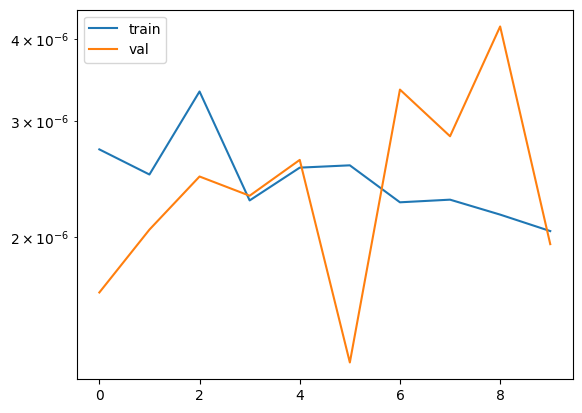

In [79]:
# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
ML_predictions = model.predict([test_x, test_prediction])
print(ML_predictions.shape)

In [ ]:
a = 0
b = 2
for i in range(200,210,1):
    plt.scatter(ML_predictions[i,a], ML_predictions[i,b], label = 'ML_prediction', s=12, marker ='x', color = 'b')
    # plt.plot(test_x[i,:,0], test_x[i,:,1], label = 'data', color = 'g')
    plt.scatter(test_answer[i,a], test_answer[i,b], label = 'answer', s=5, color = 'r')
    plt.scatter(test_prediction[i,a], test_prediction[i,b], label = 'prediction', s=10, color = 'y', marker ='o')
    plt.legend()
    plt.show()

Save the model

In [80]:
name = f"{n}_{time_span}_{c}_{str(time_step).replace('.', '')}_{str(integration_time_step).replace('.', '')}_{number_timesteps_predict}_{std}"
model.save(f'saved_models/timesteps_{number_timesteps_predict}/physical_2_data_{name}.keras')